In [ ]:
!pip install pandas numpy matplotlib seaborn

Bibliotecas importadas.
Encontrados 16 arquivos CSV. Carregando...

Shape total dos dados: (18162, 11)
Colunas: ['datetime', 'Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS', 'anomaly', 'changepoint']

Tipos de dados:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18162 entries, 2020-03-09 10:14:33 to 2020-03-09 13:34:38
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Accelerometer1RMS    18162 non-null  float64
 1   Accelerometer2RMS    18162 non-null  float64
 2   Current              18162 non-null  float64
 3   Pressure             18162 non-null  float64
 4   Temperature          18162 non-null  float64
 5   Thermocouple         18162 non-null  float64
 6   Voltage              18162 non-null  float64
 7   Volume Flow RateRMS  18162 non-null  float64
 8   anomaly              18162 non-null  float64
 9   cha

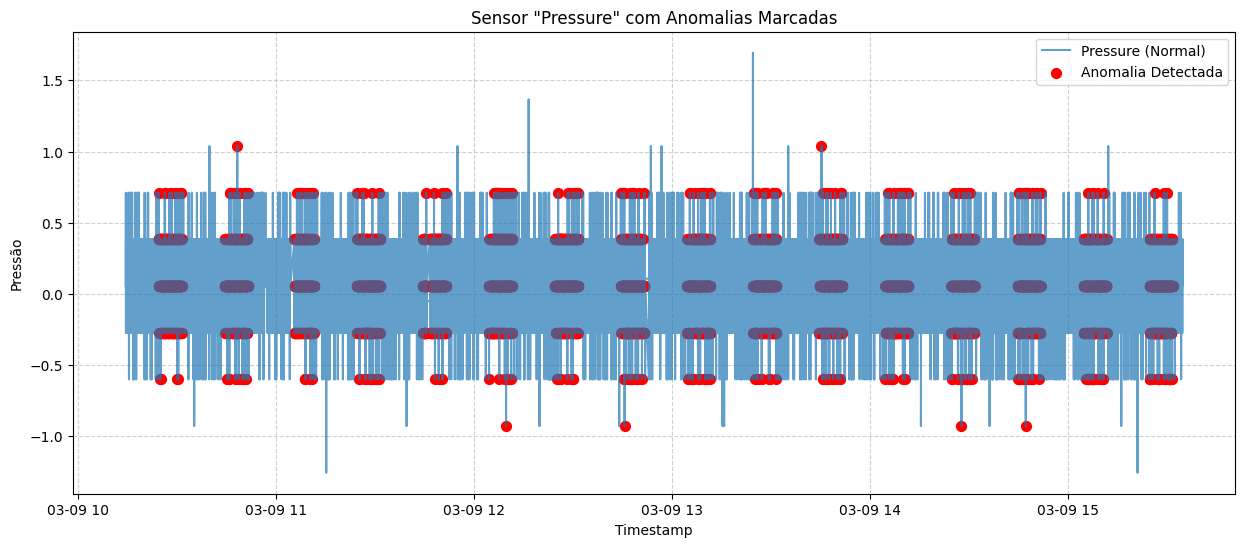


Colunas de sensores que serão usadas: ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

Shape dos dados de treino (apenas normais): (11853, 10)
Dados de treino salvos em: ../data/processed\normal_data_train.csv

Passo 2 concluído com sucesso!


In [4]:
# Célula 1: Passo 2 - Carregamento, EDA e Separação (VERSÃO CORRIGIDA)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob # Para encontrar todos os arquivos CSV

print("Bibliotecas importadas.")

# --- 2.1: Carregar todos os CSVs ---

# Caminho para os nossos dados (lembrando do ../)
data_path = '../data/raw/'

# Usar glob para encontrar todos os arquivos CSV na pasta
all_files = glob(os.path.join(data_path, "*.csv"))

# Verificar se encontramos os arquivos
if not all_files:
    print(f"Erro: Nenhum arquivo CSV encontrado em '{data_path}'")
    print("Por favor, copie os CSVs da pasta 'valve1' do zip para 'data/raw/'.")
else:
    print(f"Encontrados {len(all_files)} arquivos CSV. Carregando...")
    
    # --- CORREÇÃO 1: Adicionado sep=';' ---
    df_list = [pd.read_csv(f, sep=';') for f in all_files]
    df_full = pd.concat(df_list, ignore_index=True)
    
    # --- 2.2: Exploração Inicial (EDA) ---
    
    print("\nShape total dos dados:", df_full.shape) # Agora deve ter várias colunas
    print("Colunas:", df_full.columns.tolist())
    
    # --- CORREÇÃO 2: Mudar 'timestamp' para 'datetime' ---
    df_full['datetime'] = pd.to_datetime(df_full['datetime'])
    df_full = df_full.set_index('datetime')
    
    print("\nTipos de dados:")
    df_full.info()
    
    # Verificar a distribuição das anomalias
    anomaly_counts = df_full['anomaly'].value_counts(normalize=True) * 100
    print(f"\nDistribuição dos dados:")
    print(f"  Normais (0):   {anomaly_counts.get(0, 0):.2f}%")
    print(f"  Anomalias (1): {anomaly_counts.get(1, 0):.2f}%")

    # --- 2.3: Visualização ---
    
    # --- CORREÇÃO 3: Mudar 'Pressure_1' para 'Pressure' ---
    sensor_para_plotar = 'Pressure' # Corrigido
    
    print(f"\nPlotando Sensor '{sensor_para_plotar}' e Anomalias...")
    
    plt.figure(figsize=(15, 6))
    plt.plot(df_full[sensor_para_plotar], label=f'{sensor_para_plotar} (Normal)', alpha=0.7)
    
    # Destacar as anomalias no gráfico
    anomalies = df_full[df_full['anomaly'] == 1]
    plt.scatter(anomalies.index, anomalies[sensor_para_plotar], 
                color='red', label='Anomalia Detectada', s=50)
    
    plt.title(f'Sensor "{sensor_para_plotar}" com Anomalias Marcadas')
    plt.xlabel('Timestamp')
    plt.ylabel('Pressão')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- 2.4: Criar e Salvar o Dataset de Treino (SÓ DADOS NORMAIS) ---
    
    df_normal_train = df_full[df_full['anomaly'] == 0]
    
    # Agora que 'datetime' é o índice, esta linha funciona corretamente
    sensor_cols = [col for col in df_full.columns if col not in ['anomaly', 'changepoint']]
    print(f"\nColunas de sensores que serão usadas: {sensor_cols}")
    
    # Salvar os dados de treino para o próximo passo
    processed_dir = '../data/processed'
    os.makedirs(processed_dir, exist_ok=True)
    
    train_save_path = os.path.join(processed_dir, 'normal_data_train.csv')
    df_normal_train[sensor_cols].to_csv(train_save_path)
    
    print(f"\nShape dos dados de treino (apenas normais): {df_normal_train.shape}")
    print(f"Dados de treino salvos em: {train_save_path}")
    print("\nPasso 2 concluído com sucesso!")

In [5]:
# Célula 2: Passo 3 - Pré-processamento e Janelamento

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
import joblib

print("Iniciando Passo 3: Pré-processamento...")

# --- 3.1: Carregar os dados de treino (APENAS normais) ---
train_data_path = '../data/processed/normal_data_train.csv'

try:
    df_train = pd.read_csv(train_data_path, index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print(f"Erro: Arquivo '{train_data_path}' não encontrado.")
    print("Por favor, execute a Célula 1 primeiro.")

if 'df_train' in locals():
    print(f"Dados de treino normais carregados. Shape: {df_train.shape}")
    
    # --- 3.2: Normalização (Scaling) ---
    scaler = MinMaxScaler()
    
    # Treinar e transformar os dados de treino
    df_train_scaled = scaler.fit_transform(df_train)
    
    print("Dados normalizados (escalados entre 0 e 1).")
    
    # Salvar o scaler para uso futuro (no dashboard)
    models_dir = '../models'
    os.makedirs(models_dir, exist_ok=True)
    scaler_path = os.path.join(models_dir, 'anomaly_scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"Scaler salvo em: {scaler_path}")

    # --- 3.3: Função de Sequenciamento (Janelas Deslizantes) ---
    
    def create_sequences(data, time_steps=1):
        """
        Cria sequências (janelas) a partir de dados de sensores.
        """
        X = []
        for i in range(len(data) - time_steps + 1):
            v = data[i:(i + time_steps)]
            X.append(v)
        return np.array(X)

    # Definir o tamanho da nossa "memória" (quantos passos de tempo olhar)
    TIME_STEPS = 20 # Vamos olhar para 20 "ciclos" de cada vez
    
    # Criar as sequências
    # Note que só temos X_train. 
    # Para um Autoencoder, a entrada (X) e a saída (y) são as mesmas.
    X_train = create_sequences(df_train_scaled, TIME_STEPS)
    
    print(f"\nSequências de treino criadas com TIME_STEPS={TIME_STEPS}")
    print(f"Shape de X_train: {X_train.shape}")
    print(f"(Amostras, Passos de Tempo, Features)")

    # --- 3.4: Definir Y_train ---
    # O Autoencoder tentará reconstruir a própria entrada.
    y_train = X_train
    
    print(f"Shape de y_train: {y_train.shape}")
    
    print("\nPasso 3 concluído.")
    
    # --- Passo 4: Modelagem (Autoencoder com LSTM) ---
    print("\nIniciando Passo 4: Construção do Modelo Autoencoder...")
    
    # Pegar os 'shapes' dos dados de treino
    n_features = X_train.shape[2] # Número de sensores (ex: 8)
    input_shape = (TIME_STEPS, n_features) # (20, 8)

    # 1. ENCODER (Codificador)
    # Comprime a sequência de (20, 8) para um vetor de (16,)
    inputs = Input(shape=input_shape)
    encoder = LSTM(64, activation='relu', return_sequences=True)(inputs)
    encoder = LSTM(32, activation='relu', return_sequences=False)(encoder) # Só retorna o estado final
    
    # O "Gargalo" (Bottleneck)
    bottleneck = Dense(16, activation='relu')(encoder)

    # 2. DECODER (Decodificador)
    # Expande o vetor de (16,) de volta para uma sequência de (20, 8)
    # RepeatVector repete o vetor do gargalo 20 vezes (TIME_STEPS)
    decoder = RepeatVector(TIME_STEPS)(bottleneck)
    decoder = LSTM(32, activation='relu', return_sequences=True)(decoder)
    decoder = LSTM(64, activation='relu', return_sequences=True)(decoder)
    
    # TimeDistributed aplica uma camada Dense a cada um dos 20 passos de tempo
    output = TimeDistributed(Dense(n_features))(decoder) # n_features = 8 (saída)

    # 3. AUTOENCODER (Modelo Completo)
    autoencoder = Model(inputs=inputs, outputs=output)
    
    # Compilar
    # Usamos 'mse' (Mean Squared Error) porque queremos que a saída
    # seja o mais próximo possível da entrada.
    autoencoder.compile(optimizer='adam', loss='mse')
    
    print("Modelo Autoencoder construído e compilado.")
    autoencoder.summary()
    
    print("\nPasso 4 concluído.")

Iniciando Passo 3: Pré-processamento...
Dados de treino normais carregados. Shape: (11853, 8)
Dados normalizados (escalados entre 0 e 1).
Scaler salvo em: ../models\anomaly_scaler.pkl

Sequências de treino criadas com TIME_STEPS=20
Shape de X_train: (11834, 20, 8)
(Amostras, Passos de Tempo, Features)
Shape de y_train: (11834, 20, 8)

Passo 3 concluído.

Iniciando Passo 4: Construção do Modelo Autoencoder...
Modelo Autoencoder construído e compilado.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 8)          │           520 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,256 (247.09 KB)

 Trainable params: 63,256 (247.09 KB)

 Non-trainable params: 0 (0.00 B)


Passo 4 concluído.


Iniciando Passo 5: Treinamento e Definição do Limiar...
Iniciando o treinamento do Autoencoder...
Epoch 1/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0252 - val_loss: 0.0060
Epoch 2/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0047 - val_loss: 0.0057
Epoch 3/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 4/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0041 - val_loss: 0.0052
Epoch 5/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0040 - val_loss: 0.0051
Epoch 6/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 7/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 8/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 9/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 10/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 11/100
333/333


Treinamento concluído.
Modelo salvo com sucesso em: ../models\autoencoder_model.h5

Calculando erro de reconstrução nos dados de treino (normais)...
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Calculamos 11834 erros de reconstrução (um por janela).
Visualizando a distribuição dos erros de reconstrução...


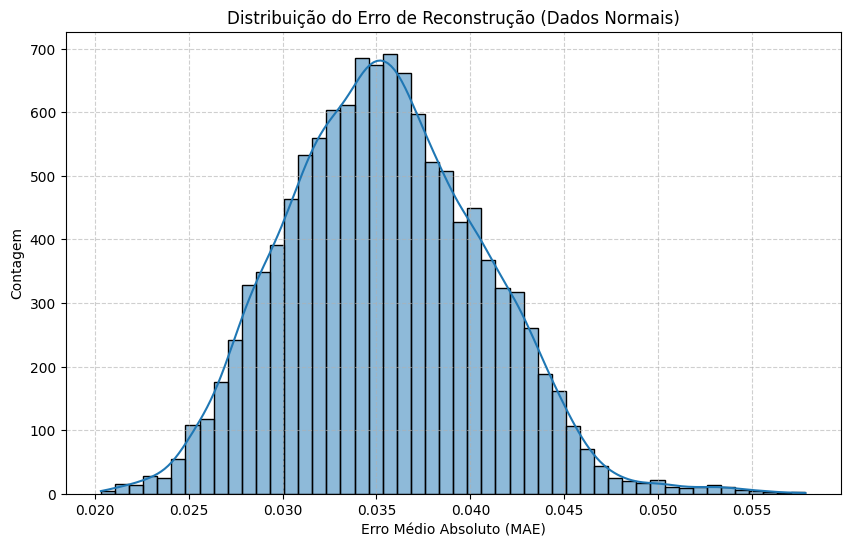


--- Limiar de Anomalia Definido ---
  Média do Erro (μ):     0.035448
  Desvio Padrão (σ):   0.005248
  Limiar (μ + 3σ):     0.051193
-------------------------------------

Qualquer janela com erro de reconstrução > 0.051193 será marcada como ANOMALIA.

Passo 5 concluído com sucesso!


In [6]:
# Célula 3: Passo 5 - Treinamento do Autoencoder e Definição do Limiar

from tensorflow.keras.callbacks import EarlyStopping

print("Iniciando Passo 5: Treinamento e Definição do Limiar...")

# Verificar se as variáveis de treino existem
if 'X_train' not in locals() or 'y_train' not in locals():
    print("Erro: Variáveis 'X_train' ou 'y_train' não encontradas.")
    print("Por favor, execute as Células 1 e 2 primeiro.")
else:
    # --- 5.1: Treinar o Modelo ---
    
    print("Iniciando o treinamento do Autoencoder...")
    
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        verbose=1, 
        restore_best_weights=True
    )

    # Treinamos o modelo com X_train como entrada e y_train (que é == X_train) como saída
    history = autoencoder.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1, # Usar 10% dos dados normais para validação
        callbacks=[early_stop],
        verbose=1
    )
    
    print("\nTreinamento concluído.")
    
    # --- 5.2: Salvar o Modelo Treinado ---
    
    # Salvar o modelo treinado na pasta /models
    # 'models_dir' foi definido na Célula 2
    model_path = os.path.join(models_dir, 'autoencoder_model.h5') 
    autoencoder.save(model_path)
    print(f"Modelo salvo com sucesso em: {model_path}")

    # --- 5.3: Calcular o Erro de Reconstrução nos Dados Normais ---
    
    print("\nCalculando erro de reconstrução nos dados de treino (normais)...")
    
    # Pedir ao modelo para "reconstruir" os dados de treino
    X_train_pred = autoencoder.predict(X_train)
    
    # Calcular o Mean Absolute Error (MAE) para CADA JANELA
    # Isso nos dá o "quão errado" o modelo estava em cada passo de tempo
    # np.mean(np.abs(X_train_pred - X_train), axis=(1, 2))
    #   axis=(1, 2) -> calcula a média sobre os 20 passos de tempo E as 8 features
    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=(1, 2))
    
    print(f"Calculamos {len(train_mae_loss)} erros de reconstrução (um por janela).")
    
    # --- 5.4: Visualizar o Erro e Definir o Limiar (Threshold) ---
    
    print("Visualizando a distribuição dos erros de reconstrução...")
    plt.figure(figsize=(10, 6))
    sns.histplot(train_mae_loss, bins=50, kde=True)
    plt.title('Distribuição do Erro de Reconstrução (Dados Normais)')
    plt.xlabel('Erro Médio Absoluto (MAE)')
    plt.ylabel('Contagem')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Definir o Limiar de Anomalia (Threshold)
    # Qualquer coisa acima deste valor será considerada uma anomalia.
    # Usamos uma regra estatística comum: Média + 3*Desvio Padrão
    
    threshold = np.mean(train_mae_loss) + (3 * np.std(train_mae_loss))
    
    print(f"\n--- Limiar de Anomalia Definido ---")
    print(f"  Média do Erro (μ):     {np.mean(train_mae_loss):.6f}")
    print(f"  Desvio Padrão (σ):   {np.std(train_mae_loss):.6f}")
    print(f"  Limiar (μ + 3σ):     {threshold:.6f}")
    print("-------------------------------------")
    print(f"\nQualquer janela com erro de reconstrução > {threshold:.6f} será marcada como ANOMALIA.")
    
    print("\nPasso 5 concluído com sucesso!")

In [ ]:
# Célula 4: Passo 6 - Avaliação do Modelo em Dados Completos

from sklearn.metrics import classification_report, confusion_matrix

print("Iniciando Passo 6: Avaliação do Modelo...")

# Verificar se as variáveis necessárias existem
if 'df_full' not in locals() or 'sensor_cols' not in locals():
    print("Erro: 'df_full' ou 'sensor_cols' não encontrados. Execute a Célula 1.")
elif 'scaler' not in locals():
    print("Erro: 'scaler' não encontrado. Execute a Célula 2.")
elif 'autoencoder' not in locals() or 'TIME_STEPS' not in locals():
    print("Erro: 'autoencoder' ou 'TIME_STEPS' não encontrados. Execute as Células 2 e 3.")
elif 'threshold' not in locals():
    print("Erro: 'threshold' não encontrado. Execute a Célula 3.")
else:
    # --- 6.1: Preparar os Dados COMPLETOS (com anomalias) ---
    
    print("Preparando dados completos (com anomalias) para avaliação...")
    
    # 1. Normalizar os dados (usando o scaler treinado SÓ com dados normais)
    df_full_scaled = scaler.transform(df_full[sensor_cols])
    
    # 2. Criar sequências (janelas) dos dados completos
    X_full = create_sequences(df_full_scaled, TIME_STEPS)
    
    print(f"Shape dos dados completos sequenciados: {X_full.shape}")

    # --- 6.2: Calcular o Erro de Reconstrução nos Dados COMPLETOS ---
    
    print("Calculando erro de reconstrução nos dados completos...")
    
    # Pedir ao modelo para "reconstruir" TODAS as janelas
    X_full_pred = autoencoder.predict(X_full)
    
    # Calcular o MAE para CADA JANELA
    full_mae_loss = np.mean(np.abs(X_full_pred - X_full), axis=(1, 2))
    
    print("Cálculo de erro concluído.")

    # --- 6.3: Criar o DataFrame de Resultados ---
    
    # O array de erros é menor que o df_full original (devido ao janelamento)
    # Precisamos pegar os rótulos de 'anomaly' que correspondem ao FINAL de cada janela
    anomaly_labels = df_full['anomaly'][TIME_STEPS - 1:].values
    
    # Criar um DataFrame para facilitar a análise
    df_results = pd.DataFrame(index=df_full.index[TIME_STEPS - 1:])
    df_results['reconstruction_error'] = full_mae_loss
    df_results['anomaly_true'] = anomaly_labels
    df_results['anomaly_pred'] = (df_results['reconstruction_error'] > threshold).astype(int)
    
    print("\nDataFrame de resultados (Erro vs. Real vs. Previsto):")
    display(df_results.head())

    # --- 6.4: Visualizar os Resultados (O "Gráfico de Fogo") ---
    
    print("\nPlotando resultados da detecção...")
    fig, ax = plt.subplots(figsize=(18, 7))

    # Plotar o erro de reconstrução
    ax.plot(df_results.index, df_results['reconstruction_error'], 
            label='Erro de Reconstrução')
    
    # Plotar o limiar (threshold)
    ax.axhline(threshold, color='red', linestyle='--', 
               label=f'Limiar (Threshold = {threshold:.6f})')
    
    # Destacar as anomalias REAIS (do dataset)
    true_anomalies_df = df_results[df_results['anomaly_true'] == 1]
    ax.scatter(true_anomalies_df.index, true_anomalies_df['reconstruction_error'], 
               color='red', label='Anomalia Real', s=60, marker='x')
    
    ax.set_title('Detecção de Anomalias vs. Erro de Reconstrução')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Erro (MAE)')
    ax.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- 6.5: Métricas de Classificação ---
    
    print("\n--- Métricas de Desempenho (Classification Report) ---")
    
    # Compara as anomalias reais (True) com as que nosso modelo previu (Pred)
    report = classification_report(df_results['anomaly_true'], df_results['anomaly_pred'], 
                                   target_names=['Normal (0)', 'Anomalia (1)'])
    print(report)
    
    print("\nMatriz de Confusão:")
    cm = confusion_matrix(df_results['anomaly_true'], df_results['anomaly_pred'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Prev. Normal', 'Prev. Anomalia'], 
                yticklabels=['Real Normal', 'Real Anomalia'])
    plt.title('Matriz de Confusão')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()
    
    print("\nPasso 6 concluído com sucesso!")